## Analysis of Sequencing Data

**This is the analysis of the sequencing data from two test plates from the 9 months CBA batch. One plate for SGN and one for Organ of Corti.**<br>
This analysis includes quality control, clustering, and annotation. Previously done clustering and cell type annotation has been preserved and was used as a guide.

In [1]:
# Importing necessary modules for ...
# ... data processing ...
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import scipy.stats as st
# import bbknn

# ... plotting ...
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc_context
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
import seaborn as sns

# ... reading and writing files
import sys, os
import json

### Plotting Configuration

This cell is simply for making pretty plots.

In [2]:
# Defining custom color map for plots
with open(r".\ColorMap.csv", "r") as file:
    my_cmap_df = pd.read_csv(file, header=0)
    my_cmap = ListedColormap(my_cmap_df["HEX_Code"].to_list())

# Defining save location for plots
figures_folder = r"C:\Users\Johann\Documents\.Personal\05 Studium\02 Tübingen Neuroscience MSc\03 Lectures\04_SS_25\02_Master_Thesis\04_Figures\Assets"

# Defining folder where raw data is stored
data_folder = r"C:\Users\Johann\Documents\.Personal\05 Studium\02 Tübingen Neuroscience MSc\03 Lectures\04_SS_25\02_Master_Thesis\03_Data\01 Sequencing Data"

# Adding custom font
fonts= [r".\Arimo\Arimo-Regular.ttf",
        r".\Arimo\Arimo-SemiBold.ttf",
        r".\Arimo\Arimo-Italic.ttf",
        r".\Arimo\Arimo-SemiBoldItalic.ttf"]
for font in fonts:
    fm.fontManager.addfont(font)

# Setting parameters for ScanPy plots
sc.set_figure_params(
    dpi_save= 600,
    facecolor= "white",
    color_map= "RdPu")

scale = 1.4 #plot scale factor
fig_width = 2.35*scale

plt.rcParams["font.family"] = "Arimo"
plt.rcParams["figure.facecolor"] = (1.0, 1.0, 1.0, 0.0)
plt.rcParams["axes.labelsize"] = 6*scale
plt.rcParams["axes.labelweight"] = "semibold"
plt.rcParams["axes.facecolor"] = (1.0, 1.0, 1.0, 0.7)
plt.rcParams["xtick.labelsize"] = 6*scale
plt.rcParams["ytick.labelsize"] = 6*scale
plt.rcParams["axes.titlesize"] = 8*scale
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams["axes.titleweight"] = "semibold"
plt.rcParams["legend.fontsize"] = 6*scale

### Reading Data

We read the data from an .h5ad file that contains the raw count matrix with some annotations and metadata.

Information carried over is:
- plate ID (a unique barcode for each 384-well plate sequenced)
- age of animals
- pre-annotated cell types (for UMAP and detailed projection)
- pre-annotated cell types corrected with batch integration
- UMAP embedding corrected with batch integration

In [3]:
# Reading the data
adata_original = sc.read_h5ad(data_folder + r"\CBA_9mo_OC_SGN_TestPlates.h5ad")

# Making a clean copy ...
adata = ad.AnnData(adata_original.X.copy())

# ... and preserving some of the metadata
adata.obs["plate"] = adata_original.obs["plate"].values.astype(str)
adata.obs["well_ID"] = adata_original.obs["WellID"].values
adata.obs["age"] = "9 months"
adata.var["spike"] = adata_original.var["spike"].values
adata.obs.set_index(adata_original.obs["index"], inplace= True)
adata.var.set_index(adata_original.var.index, inplace= True)
adata.obs["sample"] = adata.obs["plate"].map({"11279980": "SGN",
                                              "11282617": "OC"})

# Filtering out spike RNA
adata = adata[:, ~adata.var["spike"]]

adata

View of AnnData object with n_obs × n_vars = 768 × 48233
    obs: 'plate', 'well_ID', 'age', 'sample'
    var: 'spike'

### Quality Control

We calculate quality control metrics.

In [4]:
# Define mitochondrial, ribosomal, and hemoglobin genes by name
# (they are already filtered out in this dataset ...)
adata.var["mt"] = adata.var_names.str.startswith("mt-")
adata.var["ribo"] = adata.var_names.str.startswith(("Rpl", "Rps"))
adata.var["hb"] = adata.var_names.str.startswith("Hb")

print(f"{len(adata.var[adata.var["mt"]])} Mitochondrial genes identified:\n", adata.var_names[adata.var["mt"]].values, "\n")
print(f"{len(adata.var[adata.var["ribo"]])} Ribosomal genes identified:\n", adata.var_names[adata.var["ribo"]].values, "\n")
print(f"{len(adata.var[adata.var["hb"]])} Hemoglobin genes identified:\n", adata.var_names[adata.var["hb"]].values)

# Calculating QC metrics including the gene subsets
sc.pp.calculate_qc_metrics(adata, qc_vars= ["mt", "ribo", "hb"],
                           inplace= True,
                           log1p= True)

adata.obs

C:\Users\Johann\AppData\Local\Temp\ipykernel_35056\286140658.py:3: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("mt-")


37 Mitochondrial genes identified:
 ['mt-Tf' 'mt-Rnr1' 'mt-Tv' 'mt-Rnr2' 'mt-Tl1' 'mt-Nd1' 'mt-Ti' 'mt-Tq'
 'mt-Tm' 'mt-Nd2' 'mt-Tw' 'mt-Ta' 'mt-Tn' 'mt-Tc' 'mt-Ty' 'mt-Co1'
 'mt-Ts1' 'mt-Td' 'mt-Co2' 'mt-Tk' 'mt-Atp8' 'mt-Atp6' 'mt-Co3' 'mt-Tg'
 'mt-Nd3' 'mt-Tr' 'mt-Nd4' 'mt-Th' 'mt-Ts2' 'mt-Tl2' 'mt-Nd5' 'mt-Nd6'
 'mt-Te' 'mt-Cytb' 'mt-Tt' 'mt-Tp' 'mt-Nd4l'] 

405 Ribosomal genes identified:
 ['Rpl13' 'Rpl3l' 'Rps11' 'Rps6ka1' 'Rpl8' 'Rps9' 'Rplp1' 'Rps18' 'Rpl10'
 'Rps15a' 'Rps25' 'Rpl15' 'Rps5' 'Rpl19' 'Rps6kl1' 'Rps27a' 'Rps6kb1'
 'Rps6ka5' 'Rps6ka2' 'Rpl36-ps2' 'Rps14' 'Rps6kb2' 'Rps24' 'Rps26' 'Rplp2'
 'Rps6ka6' 'Rpl14' 'Rpl7-ps8' 'Rps3a1' 'Rps20' 'Rps6' 'Rpl22' 'Rpl6'
 'Rpl28' 'Rps3' 'Rps6ka3' 'Rps4x' 'Rpl4' 'Rpsa' 'Rps29' 'Rpl39-ps'
 'Rps27l' 'Rps16' 'Rpl10a' 'Rpl12' 'Rps21' 'Rpl39l' 'Rpl22l1' 'Rps19'
 'Rpl21' 'Rpl37' 'Rpl7' 'Rps2' 'Rpsa-ps2' 'Rpl18a' 'Rpl37a' 'Rpl27a'
 'Rps4l-ps' 'Rps11-ps4' 'Rpl14-ps1' 'Rpl9' 'Rps8' 'Rpsa-ps10' 'Rpl9-ps7'
 'Rpl29' 'Rps23' 'Rpl36al' 'Rps27rt'

plate well_ID       age sample  n_genes_by_counts  \
index                                                                        
CCAATGAAGGAACAGCTCCA  11279980     G16  9 months    SGN               2012   
CCAATGAAGGAACGACCTTC  11279980     G20  9 months    SGN               2583   
CCAATGAAGGAAGGTGCCTA  11279980     G24  9 months    SGN               1978   
CCAATGAAGGACATTCGGAG  11279980      G2  9 months    SGN               1489   
CCAATGAAGGACTGACCAGA  11279980      G1  9 months    SGN               1884   
...                        ...     ...       ...    ...                ...   
TTGTTACTCCGTTCGCTGAT  11282617     F10  9 months     OC               4314   
TTGTTACTCCTCGCACCAAT  11282617      F2  9 months     OC               3506   
TTGTTACTCCTCGGATACGT  11282617     F12  9 months     OC               4246   
TTGTTACTCCTGATAGGAGG  11282617     F23  9 months     OC               3765   
TTGTTACTCCTGATTCCACG  11282617     F14  9 months     OC               4468   

                      log1p_n_genes_by_counts  total_counts  \
index                                                         
CCAATGAAGGAACAGCTCCA                 7.607381        2842.0   
CCAATGAAGGAACGACCTTC                 7.857094        5504.0   
CCAATGAAGGAAGGTGCCTA                 7.590347        2836.0   
CCAATGAAGGACATTCGGAG                 7.306531        2795.0   
CCAATGAAGGACTGACCAGA                 7.541683        3928.0   
...                                       ...           ...   
TTGTTACTCCGTTCGCTGAT                 8.369853       10523.0   
TTGTTACTCCTCGCACCAAT                 8.162516        8600.0   
TTGTTACTCCTCGGATACGT                 8.353968       11221.0   
TTGTTACTCCTGATAGGAGG                 8.233769        8795.0   
TTGTTACTCCTGATTCCACG                 8.404920       10746.0   

                      log1p_total_counts  pct_counts_in_top_50_genes  \
index                                                                  
CCAATGAAGGAACAGCTCCA            7.952615                   14.004222   
CCAATGAAGGAACGACCTTC            8.613412                   17.587209   
CCAATGAAGGAAGGTGCCTA            7.950502                   16.643159   
CCAATGAAGGACATTCGGAG            7.935945                   22.647585   
CCAATGAAGGACTGACCAGA            8.276140                   19.424644   
...                                  ...                         ...   
TTGTTACTCCGTTCGCTGAT            9.261414                   17.628053   
TTGTTACTCCTCGCACCAAT            9.059634                   19.011628   
TTGTTACTCCTCGGATACGT            9.325631                   16.148293   
TTGTTACTCCTGATAGGAGG            9.082052                   15.884025   
TTGTTACTCCTGATTCCACG            9.282382                   14.200633   

                      pct_counts_in_top_100_genes  ...  \
index                                              ...   
CCAATGAAGGAACAGCTCCA                    19.282196  ...   
CCAATGAAGGAACGACCTTC                    24.745640  ...   
CCAATGAAGGAAGGTGCCTA                    21.932299  ...   
CCAATGAAGGACATTCGGAG                    33.381038  ...   
CCAATGAAGGACTGACCAGA                    27.367617  ...   
...                                           ...  ...   
TTGTTACTCCGTTCGCTGAT                    22.607621  ...   
TTGTTACTCCTCGCACCAAT                    24.848837  ...   
TTGTTACTCCTCGGATACGT                    21.441939  ...   
TTGTTACTCCTGATAGGAGG                    21.500853  ...   
TTGTTACTCCTGATTCCACG                    19.002420  ...   

                      pct_counts_in_top_500_genes  total_counts_mt  \
index                                                                
CCAATGAAGGAACAGCTCCA                    46.798030             17.0   
CCAATGAAGGAACGACCTTC                    53.015988             22.0   
CCAATGAAGGAAGGTGCCTA                    47.884344             39.0   
CCAATGAAGGACATTCGGAG                    64.615385             13.0   
CCAATGAAGGACTGACCAGA                    58.401222             15.0   
...     

In [5]:
# Calculating MAD for a given QC metric
def is_outlier(adata, metric: str, nmads: int):
    '''This function calculates whether each element of a list or series is an
    outlier based on the number of median absolute deviations (MADs) passed in the
    arguments nmads. It returns a list of booleans where each element that was an outlier
    in the original list results in a TRUE in the returned list. If you use the returned
    list for indexing to EXCLUDE outliers, remember to index with the inverse (~outliers) of the outlier
    list returned by this function'''
    M = adata.obs[metric]
    outlier = ((M < np.median(M) - nmads * st.median_abs_deviation(M)) # outlier below ...
               | (np.median(M) + nmads * st.median_abs_deviation(M) < M)) # and outlier above
    return outlier

# Defining whether a nucleus is an outlier based on total counts and gene counts per cell
adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", 4)
                        | is_outlier(adata, "log1p_n_genes_by_counts", 4)
                        | (adata.obs["n_genes_by_counts"] < 2000)) # Custom hard threshold for minimum gene number per nucleus due to Smart-seq3xpress performance

# Running doublet detection and creating a doublet score for every cell
sc.pp.scrublet(adata, batch_key= "plate")

print(f"Identified {len(adata.obs[adata.obs["outlier"]])} out of {len(adata.obs)} nuclei as outliers.\n")

Identified 175 out of 768 nuclei as outliers.



C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\plotting\_anndata.py:967: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\plotting\_anndata.py:967: UserWarning: The palette list has more values (45) than needed (2), which may not be intended.
  sns.violinplot(
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\plotting\_anndata.py:967: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for th

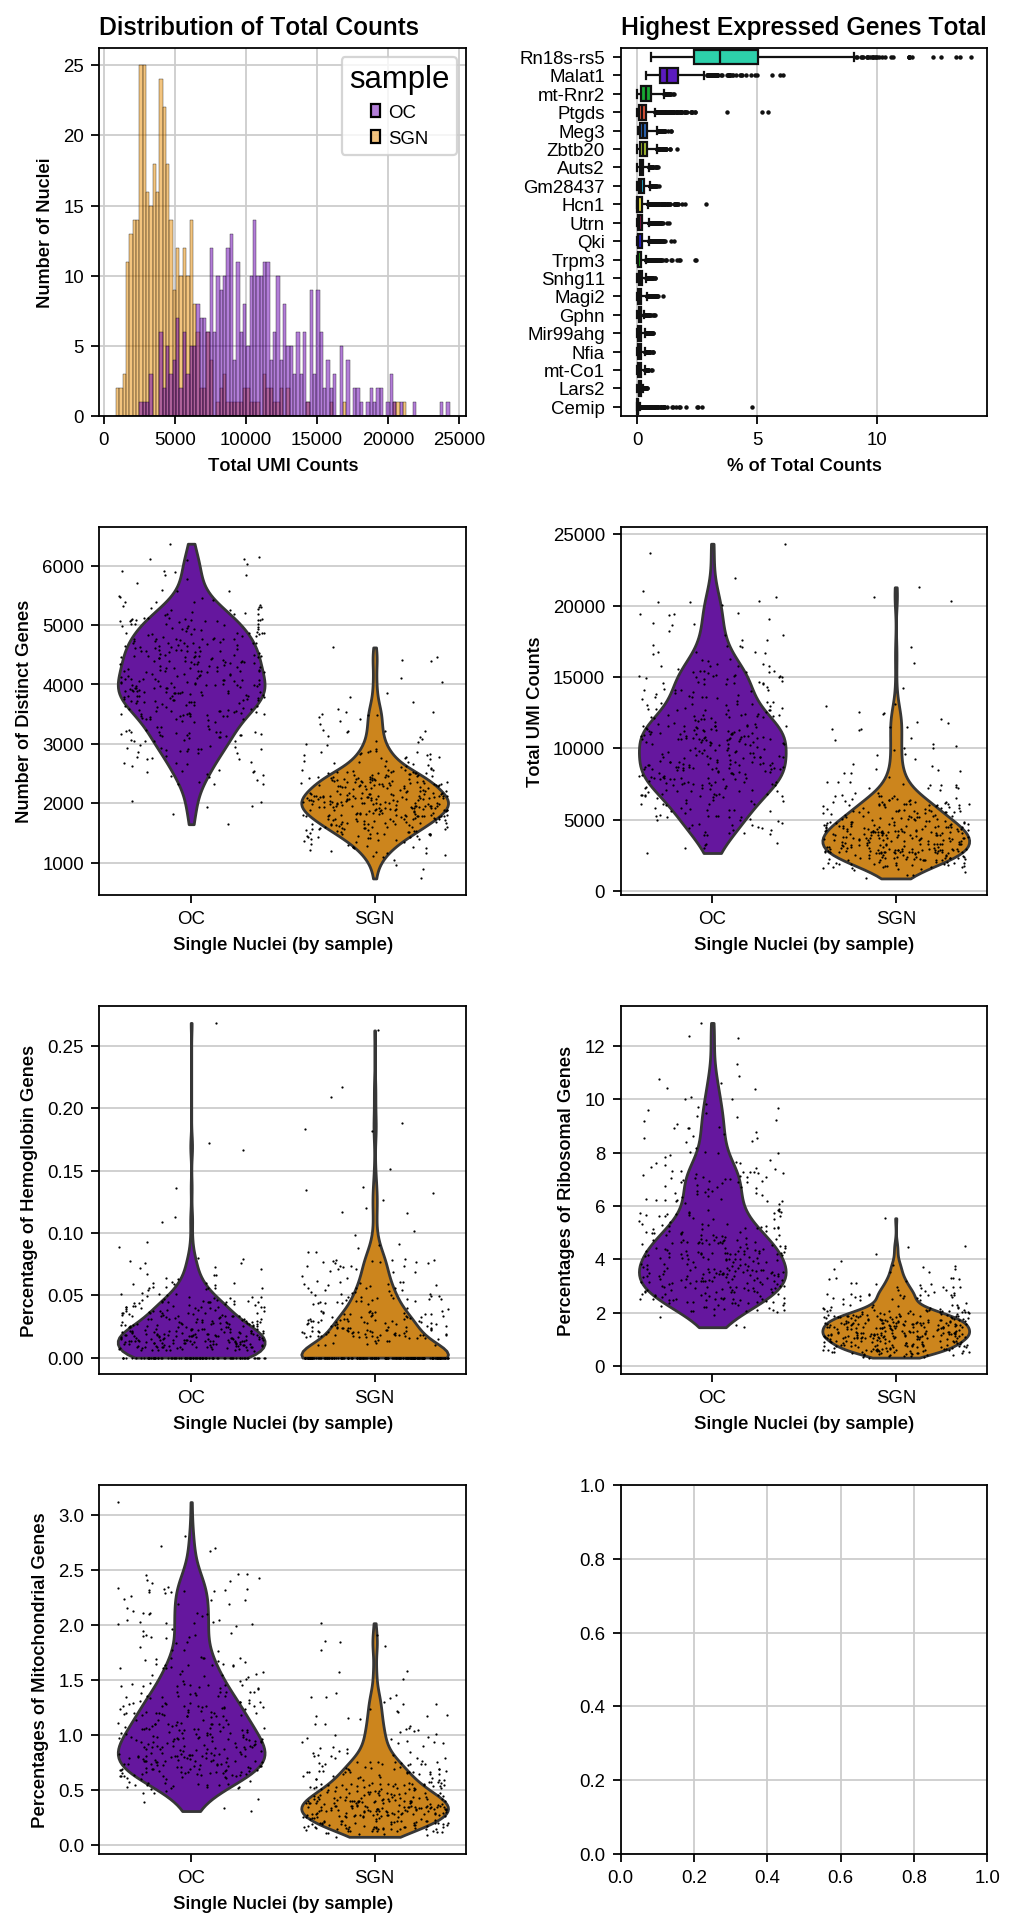

In [6]:
fig, axes = plt.subplots(4, 2, figsize=(fig_width*2, fig_width*2.8*1.333), layout= "constrained")

sc.pl.violin(adata, ["n_genes_by_counts"],
             groupby= "sample",
             jitter= 0.4,
             ax= axes[1, 0],
             show= False,
             palette = my_cmap.colors,
             zorder= 2)
axes[1, 0].set_ylabel("Number of Distinct Genes")
axes[1, 0].set_xlabel("Single Nuclei (by sample)")

sc.pl.violin(adata, ["total_counts"],
             groupby= "sample",
             jitter= 0.4,
             ax= axes[1, 1],
             show= False,
             palette = my_cmap.colors,
             zorder= 2)
axes[1, 1].set_ylabel("Total UMI Counts")
axes[1, 1].set_xlabel("Single Nuclei (by sample)")

sc.pl.violin(adata, ["pct_counts_hb"],
             groupby= "sample",
             jitter= 0.4,
             ax= axes[2, 0],
             show= False,
             palette = my_cmap.colors,
             zorder= 2)
axes[2, 0].set_ylabel("Percentage of Hemoglobin Genes")
axes[2, 0].set_xlabel("Single Nuclei (by sample)")

sc.pl.violin(adata, ["pct_counts_ribo"],
             groupby= "sample",
             jitter= 0.4,
             ax= axes[2, 1],
             show= False,
             palette = my_cmap.colors,
             zorder= 2)
axes[2, 1].set_ylabel("Percentages of Ribosomal Genes")
axes[2, 1].set_xlabel("Single Nuclei (by sample)")

sc.pl.violin(adata, ["pct_counts_mt"],
             groupby= "sample",
             jitter= 0.4,
             ax= axes[3, 0],
             show= False,
             palette = my_cmap.colors,
             zorder= 2)
axes[3, 0].set_ylabel("Percentages of Mitochondrial Genes")
axes[3, 0].set_xlabel("Single Nuclei (by sample)")

sc.pl.highest_expr_genes(adata, n_top=20, ax= axes[0, 1], show= False, palette= my_cmap.colors[2:])
axes[0, 1].set_title("Highest Expressed Genes Total")
# axes[0, 1].set_xlim(0, 10)
axes[0, 1].set_xlabel(r"% of Total Counts")

sns.histplot(adata.obs, x= "total_counts", bins = 100, kde= False, ax= axes[0, 0], palette= my_cmap.colors, zorder= 2, hue= "sample")
axes[0, 0].set_title("Distribution of Total Counts")
axes[0, 0].set_xlabel("Total UMI Counts")
axes[0, 0].set_ylabel("Number of Nuclei")

fig.tight_layout(h_pad= 1.0*scale)
fig.savefig(figures_folder + r"\QC_metrics_TestPlates.png")
plt.show()

### Normalization

We normalize the data using analytical pearson residuals.

In [7]:
# Saving a copy of the raw counts before normalising
adata.layers["raw_counts"] = adata.X.copy()

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\experimental\pp\_normalization.py:76: RuntimeWarning: invalid value encountered in divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)


C:\Users\Johann\AppData\Local\Temp\ipykernel_35056\520005917.py:12: UserWarning: The palette list has more values (45) than needed (1), which may not be intended.
  sns.histplot(adata.X.sum(1), bins = 100, kde= False, ax= axes[0], palette= my_cmap.colors, legend= False)
C:\Users\Johann\AppData\Local\Temp\ipykernel_35056\520005917.py:19: UserWarning: The palette list has more values (45) than needed (1), which may not be intended.
  sns.histplot(adata.layers["log1p_normalized_counts"].sum(1), bins = 100, kde= False, ax= axes[2], palette= my_cmap.colors, legend= False)


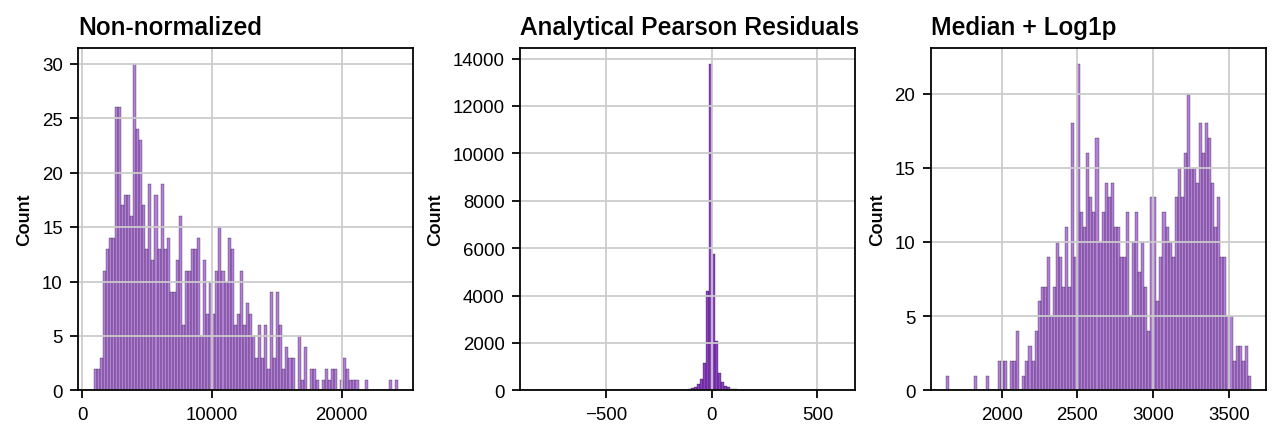

In [9]:
# Normalize the data and store the normalizations in separate layers ...
# ... by pearson residulals ...
adata.layers["pearson_normalized_counts"] = sc.experimental.pp.normalize_pearson_residuals(adata, copy= True).X

# ... and by median (with log1p transformation)
adata.layers["log1p_normalized_counts"] = sc.pp.normalize_total(adata, copy= True).X
sc.pp.log1p(adata, layer= "log1p_normalized_counts")

fig, axes = plt.subplots(1, 3, figsize=(fig_width*2.4, fig_width*0.8), layout= "constrained")

# the original layer remains raw
sns.histplot(adata.X.sum(1), bins = 100, kde= False, ax= axes[0], palette= my_cmap.colors, legend= False)
axes[0].set_title("Non-normalized")

sns.histplot(adata.layers["pearson_normalized_counts"].sum(0), bins = 100, kde= False, ax= axes[1], color= my_cmap.colors[0])
axes[1].set_title("Analytical Pearson Residuals")


sns.histplot(adata.layers["log1p_normalized_counts"].sum(1), bins = 100, kde= False, ax= axes[2], palette= my_cmap.colors, legend= False)
axes[2].set_title("Median + Log1p")

plt.show()
fig.savefig(figures_folder + r"\Normalization_Comparison_Testplates.png")

### Feature Selection

We select the top 2000 most highly variable genes (HVGs) based on pearson residuals.

In [10]:
# Feature selection based on pearson residuals
sc.experimental.pp.highly_variable_genes(adata, n_top_genes= 2000, batch_key= "age", layer= "raw_counts") # We tell it to use the raw counts
# sc.pp.highly_variable_genes(adata, n_top_genes= 2000)

# Plotting highly variable gene fraction
fig, ax = plt.subplots(1,1, figsize=(fig_width*0.8, fig_width*0.8), layout= "constrained")

sns.scatterplot(adata.var, x= "means", y= "residual_variances",
                hue= "highly_variable", 
                palette= my_cmap.colors,
                ax= ax, 
                s= 5,
                edgecolor= "black",
                linewidth= 0.1,
                zorder= 2)
ax.set_title("Highly Variable Genes Pearson")
ax.legend(["Common", "Highly Variable"])
ax.set_xscale("log")
ax.set_yscale("log")

fig.savefig(figures_folder + r"\HVGs_TestPlates.png")
plt.show()

C:\Users\Johann\AppData\Local\Temp\ipykernel_35056\2389627256.py:8: UserWarning: The palette list has more values (45) than needed (2), which may not be intended.
  sns.scatterplot(adata.var, x= "means", y= "residual_variances",


### Dimensionality Reduction

We compute principal components on the pearson normalized count matrix.

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\plotting\_tools\scatterplots.py:468: UserWarning: Adding colorbar to a different Figure <Figure size 473.76x210.56 with 3 Axes> than <Figure size 320x320 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(


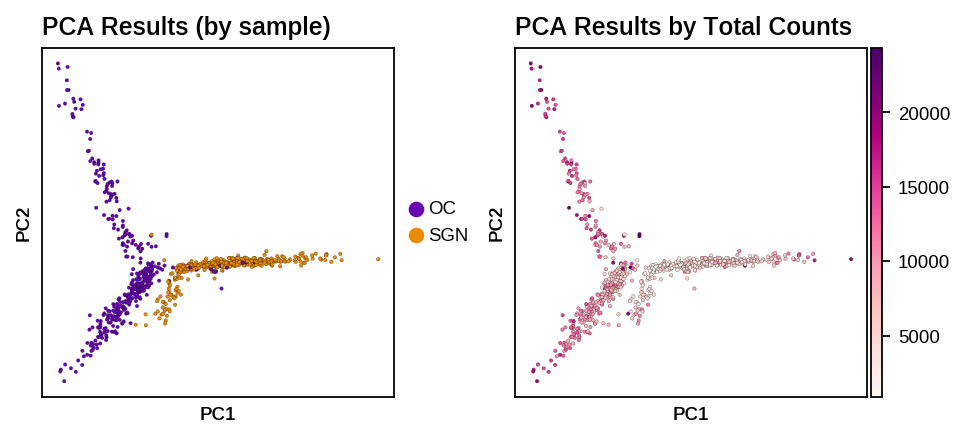

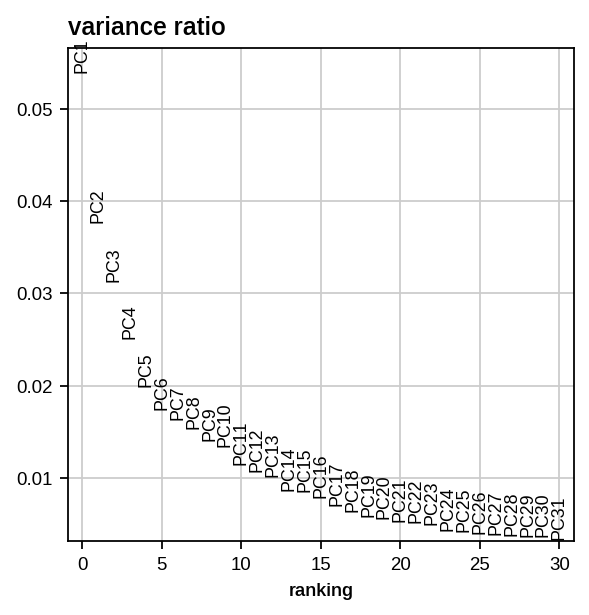

In [11]:
# Computing PCA with pearson residuals on the raw count matrix
adata.X = adata.layers["raw_counts"].copy()
sc.experimental.pp.normalize_pearson_residuals_pca(adata, n_comps= 50)
# sc.pp.pca(adata, use_highly_variable= True, svd_solver= "arpack")

# We inspect the PCA results
fig, axes = plt.subplots(1, 2, figsize=(fig_width*1.8, fig_width*0.8), layout= "compressed")

sc.pl.pca_variance_ratio(adata, show= False)

# PCA by plate
sc.pl.pca(adata, color= "sample",
          palette= my_cmap.colors,
          s= 10,
          edgecolor= "black",
          linewidth= 0.1,
          ax= axes[0],
          sort_order= False,
          show= False)
axes[0].set_title("PCA Results (by sample)")

# PCA by total counts
sc.pl.pca(adata, color= "total_counts",
          s= 10,
          edgecolor= "black",
          linewidth= 0.1,
          ax= axes[1],
          sort_order= False,
          show= False)
axes[1].set_title("PCA Results by Total Counts")

fig.savefig(figures_folder + r"\PCA_Results_TestPlates.png")
plt.show()

### UMAP Embedding

We batch correct the data by calculating a batch-balances k-nearest neighbor (BBKNN) graph and calculate a UMAP projection.
The batch covariate is the plateID, so we correct for differences between each plate.

In [12]:
# BBKNN embedding
adata.X = adata.layers["pearson_normalized_counts"].copy()
# bbknn.bbknn(adata, batch_key= "plate", neighbors_within_batch= 3, )
sc.pp.neighbors(adata)

# UMAP Embedding
sc.tl.umap(adata, spread= 1.6, min_dist= 1.2)

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


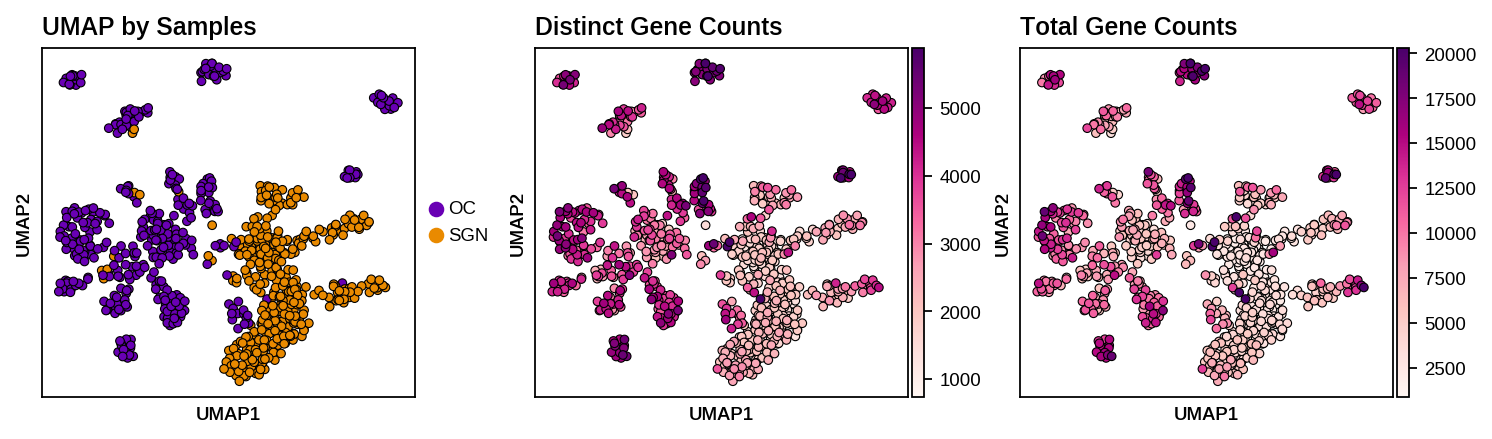

In [13]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize= (fig_width*2.8, fig_width*0.8), layout= "compressed")

dot_size = 60
vmax = "p99"
sc.pl.umap(adata,
           color=["total_counts"],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.5,
           ax= axs[2],
           show= False)
axs[2].set_title("Total Gene Counts")

sc.pl.umap(adata,
           color=["n_genes_by_counts"],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.5,
           ax= axs[1],
           show= False)
axs[1].set_title("Distinct Gene Counts")


sc.pl.umap(adata,
           color=["sample"],
           palette= my_cmap.colors,
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.5,
           ax= axs[0],
           show= False,
           title= "UMAP by Samples")

# fig.tight_layout(w_pad= 0.2)
fig.savefig(figures_folder + r"\UMAP_Prefilter_TestPlates.png")
plt.show()

### Filtering

We filter out cells and genes that we determined to be outliers as defined above.

In [14]:
# And this is also what we have to do with out custom "outlier" annotations
print(f"Number of cells before outliers: {adata.n_obs}")
adata = adata[(~adata.obs["outlier"])]
print(f"Number of cells after outliers: {adata.n_obs}\n")

print(f"Number of cells before count exclusion: {adata.n_obs}")
sc.pp.filter_cells(adata, min_genes= 100, inplace= True)
sc.pp.filter_genes(adata, min_cells= 3, inplace= True)
print(f"Number of cells after count exclusion: {adata.n_obs}")

Number of cells before outliers: 768
Number of cells after outliers: 593

Number of cells before count exclusion: 593


C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\preprocessing\_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


Number of cells after count exclusion: 593


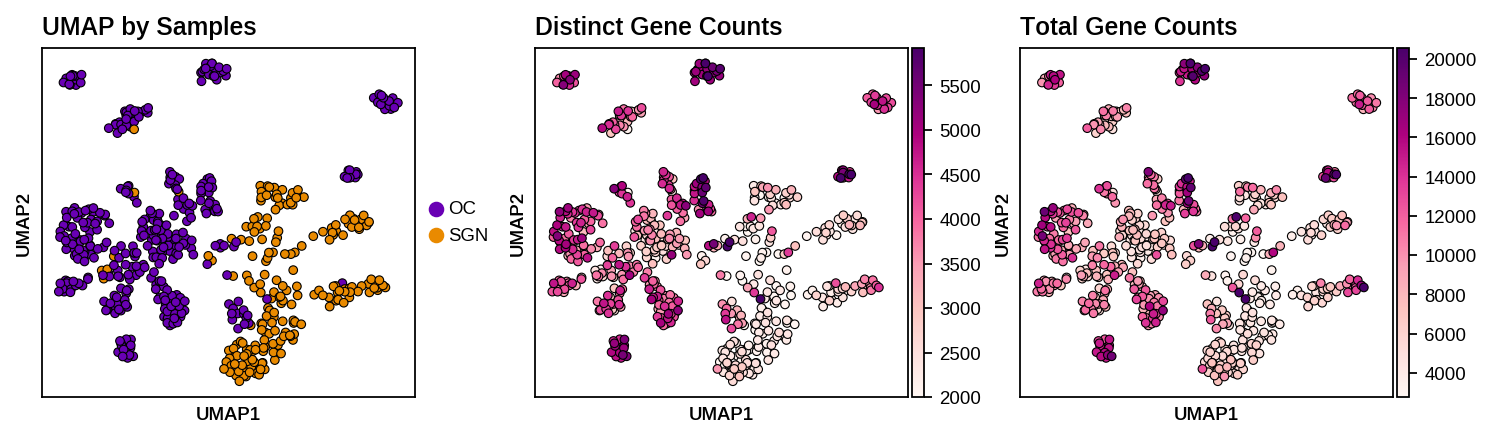

In [15]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize= (fig_width*2.8, fig_width*0.8), layout= "compressed")

dot_size = 60
vmax = "p99"
sc.pl.umap(adata,
           color=["total_counts"],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.5,
           ax= axs[2],
           show= False)
axs[2].set_title("Total Gene Counts")

sc.pl.umap(adata,
           color=["n_genes_by_counts"],
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.5,
           ax= axs[1],
           show= False)
axs[1].set_title("Distinct Gene Counts")


sc.pl.umap(adata,
           color=["sample"],
           palette= my_cmap.colors,
           size= dot_size,
           vmax= vmax,
           edgecolor= "black",
           linewidth= 0.5,
           ax= axs[0],
           show= False,
           title= "UMAP by Samples")

# fig.tight_layout(w_pad= 0.2)
fig.savefig(figures_folder + r"\UMAP_Postfilter_TestPlates.png")
plt.show()

### Clustering

We cluster using the Leiden algorithm.

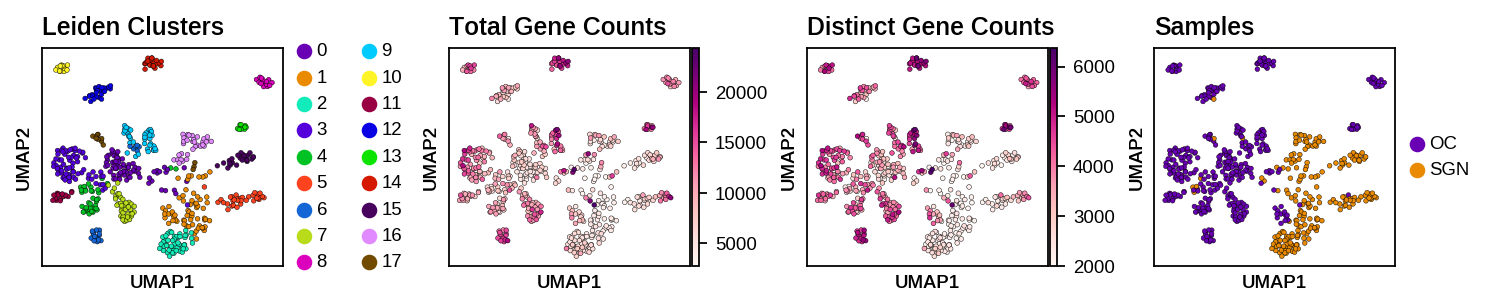

In [16]:
# adata.X = adata.layers["pearson_normalized_counts"].copy()
sc.tl.leiden(adata, flavor= "igraph", n_iterations= -1, key_added= "leiden")

# Plotting the clusters
fig, ax = plt.subplots(1,4, figsize= (fig_width*2.8, fig_width*0.55), layout= "compressed")

for i, metric in enumerate(["leiden", "total_counts", "n_genes_by_counts", "sample"]):
    sc.pl.umap(adata, color= metric,
               palette= my_cmap.colors,
               size= 18,
               edgecolor= "black",
               linewidth= 0.2,
               ax= ax[i],
               show= False)
ax[0].set_title("Leiden Clusters")
ax[1].set_title("Total Gene Counts")
ax[2].set_title("Distinct Gene Counts")
ax[3].set_title("Samples")

fig.savefig(figures_folder + r"\Leiden_Clustering_PostFilter_TestPlates.png")
plt.show()

In [17]:
# Marker Genes
# Loading previously saved markers
with open("cochlea_markers.json", "r") as file:
    markers_SGN = json.load(file)

# Checking which marker genes are present in the dataset
markers_in_data = {}
for ct, markers in markers_SGN.items():
    if np.intersect1d(markers, adata.var_names).size > 0:
        markers_in_data[ct] = list(np.intersect1d(markers, adata.var_names))

# printing the final list of available marker genes
print("Marker genes present in data:\n")
for item in markers_in_data.items():
    print(f"{item[0]}: {item[1]}")

selection_markers = dict()
ct_selection = ["Inner Hair Cells",
                "Outer Hair Cells"]
for ct in ct_selection:
    selection_markers[ct] = markers_in_data[ct]
    print(selection_markers)

Marker genes present in data:

Hair Cells: ['Cib2', 'Myo6', 'Myo7a', 'Ocm']
Inner Hair Cells: ['Otof', 'Slc17a8']
Outer Hair Cells: ['Ikzf2', 'Kcnq4', 'Slc26a5', 'Strc']
Deiter Cells: ['Ceacam16', 'Crhr1', 'Fabp3', 'Fgfr3', 'Gdf6', 'Plxnb2']
Inner Pillar Cells: ['Bmp6', 'Fgfr3', 'Lgr5']
Outer Pillar Cells: ['Cd44', 'Fgfr3']
Inner Phalangeal Cells: ['Cpa6', 'Far1', 'Gpc2', 'Otog', 'Slc1a3']
Claudius Cells: ['Aqp4', 'Car12', 'Cobl', 'Otoa', 'Rspo2']
Hensen Cells: ['Cd44', 'Cobl', 'Dpysl4', 'Lockd', 'Zbtb20']
Boettcher Cells: ['Car12', 'Rspo2']
Inner Sulcus Cells: ['Aqp4', 'Bmp4']
Interdental Cells: ['Ceacam16', 'Otoa']
Macrophages: ['C1qb', 'Csf1r', 'Fcgr3', 'Lgmn', 'Mrc1', 'Ptprc']
Endothelial Cells: ['Cdh5', 'Esam', 'Flt1', 'Tie1']
Pericytes: ['Cspg4', 'Pdgfrb', 'Rgs5']
Intermediate Cells: ['Col5a3', 'Dct', 'Kcnj10']
Marginal Cells: ['Bsnd', 'Kcne1']
Basal Cells: ['Atp6v0a4', 'Cldn11']
Spindle Cells: ['Anxa1', 'Dpp10', 'Slc26a4']
Root Cells: ['Epyc', 'Lgr5', 'Slc26a4']
Reissner Cells: 

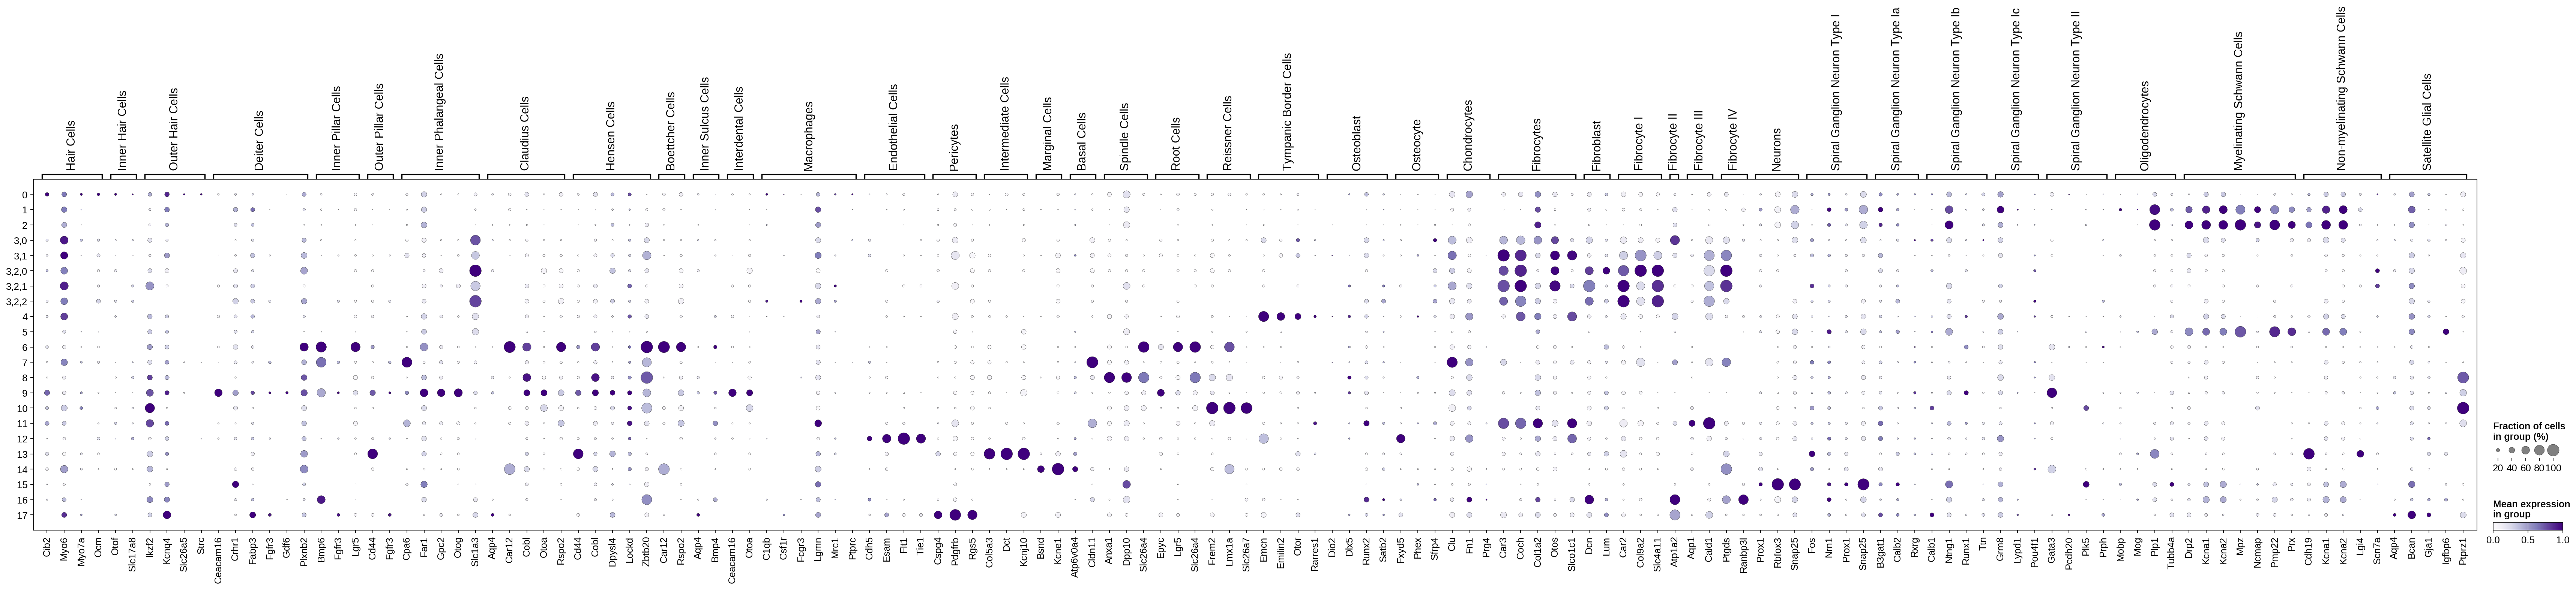

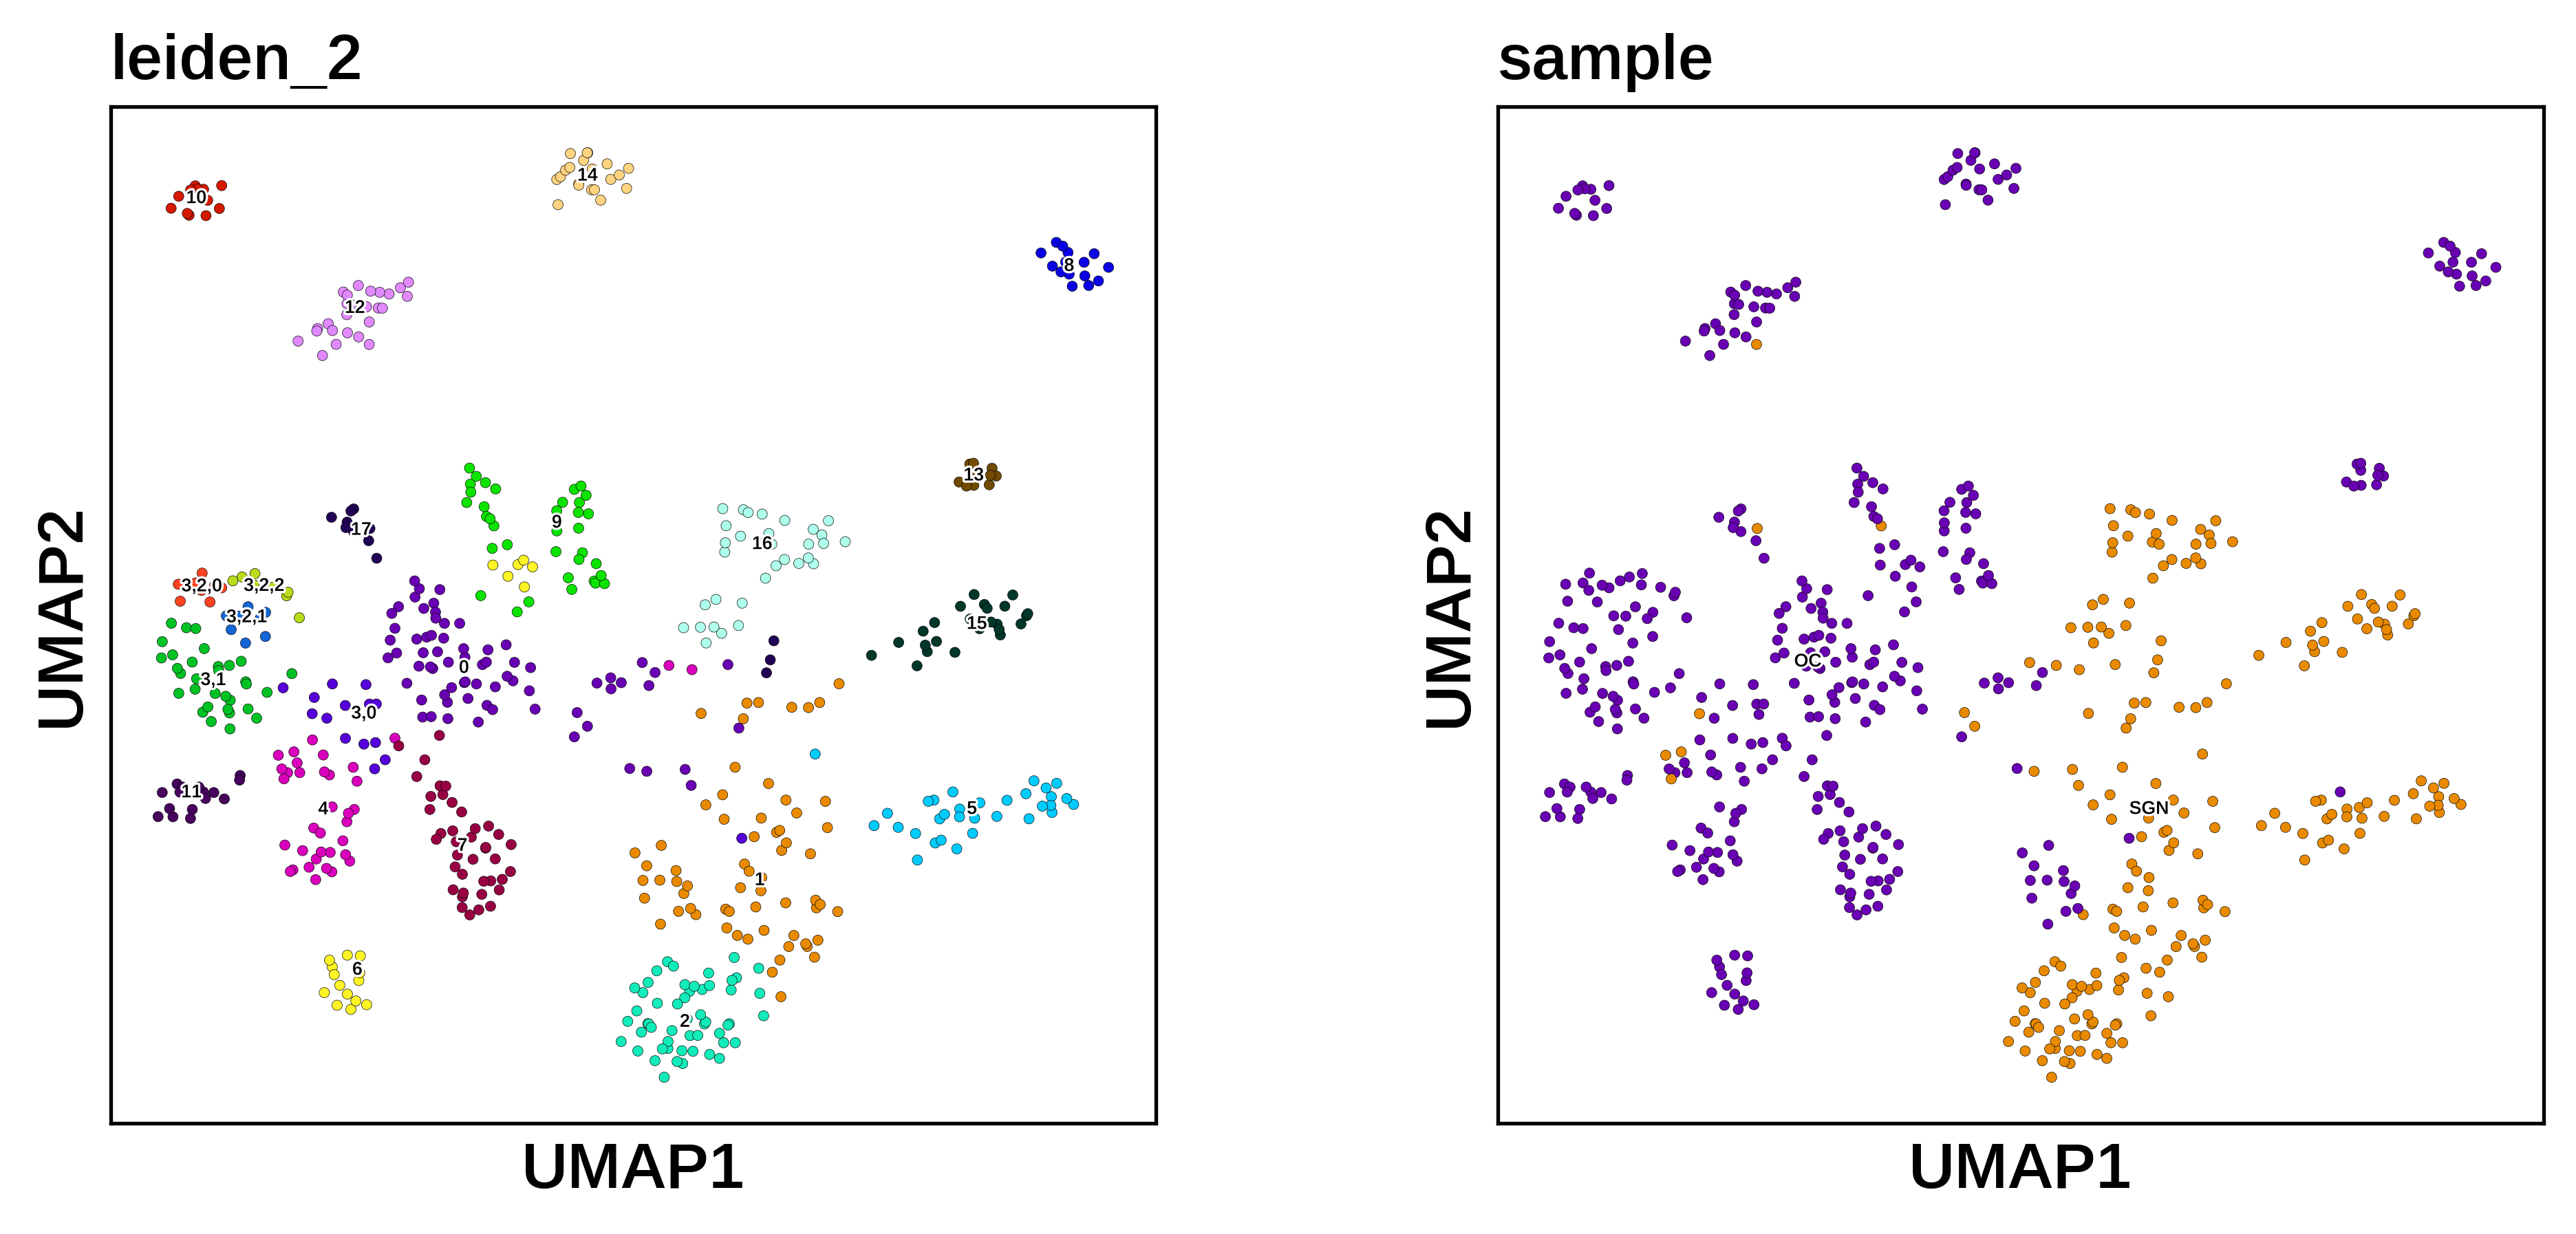

In [18]:
# Next, we check the expression patterns of the marker genes in our clustering
sc.tl.leiden(adata,
             flavor= "igraph",
             n_iterations= -1,
             key_added= "leiden_0")

# After initial inspection, defining clusters that need sub-clustering
need_subclustering = {"3": 0.6,
                      "3,2": 1}

# Successive sub-clustering of clusters that are too coarse to tell cell types apart
if len(need_subclustering) > 0:
    i = 1
    for cluster, res in need_subclustering.items():
        sc.tl.leiden(adata, flavor= "igraph", n_iterations= -1, key_added= f"leiden_{i}",
                    resolution= res,
                    restrict_to= (f"leiden_{i-1}", [cluster]))
        i += 1

# Dotplot featuring all marker genes and all the clusters to manually determine cell identities in clusters
# THIS IS WHERE THE ACTUAL CLUSTER ANNOTATION CALLING HAPPENS
sc.pl.dotplot(adata,
              markers_in_data,
              groupby=f"leiden_{len(need_subclustering)}",
              standard_scale= "var",
              cmap= "Purples") # I like purple

sc.set_figure_params(dpi= 240)
sc.pl.umap(adata,
           color=[f"leiden_{len(need_subclustering)}", "sample"],
           legend_loc="on data",
           legend_fontsize= 4,
           legend_fontoutline= 1,
           size= 20,
           palette= my_cmap.colors,
           edgecolor= "black",
           linewidth= 0.1)
sc.set_figure_params(dpi= 90)

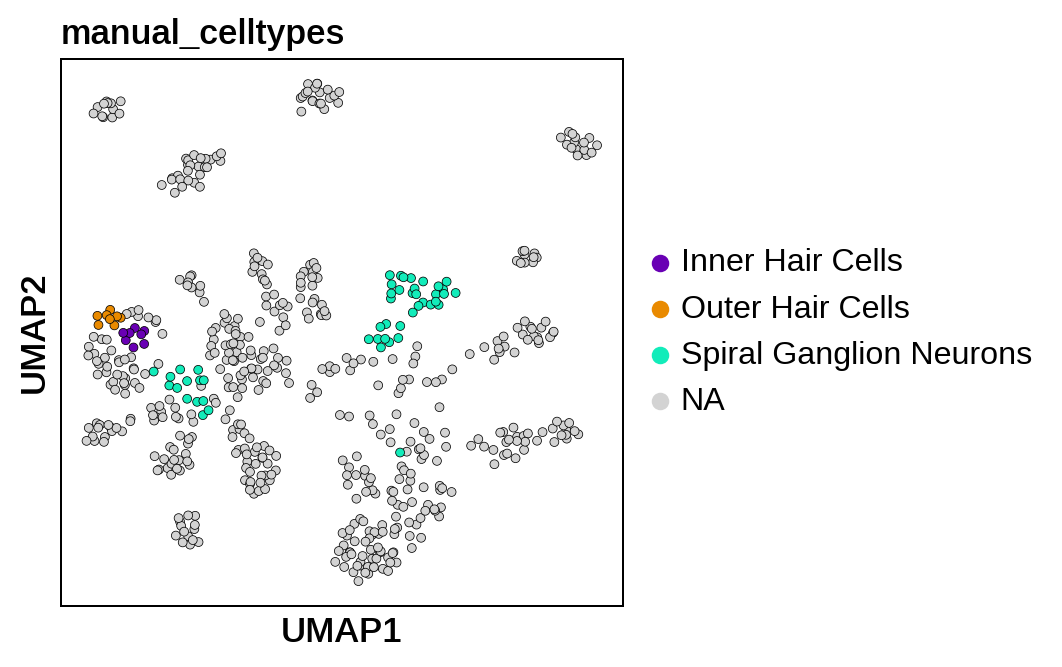

In [19]:
manual_celltypes = {"3,0": "Spiral Ganglion Neurons",
                    "16": "Spiral Ganglion Neurons",
                    "3,2,1": "Inner Hair Cells",
                    "3,2,0": "Outer Hair Cells"}

adata.obs["manual_celltypes"] = adata.obs[f"leiden_{len(need_subclustering)}"].map(manual_celltypes)

sc.pl.umap(adata,
           color= "manual_celltypes",
           edgecolor= "black",
           size= 50,
           linewidth= 0.3,
           palette= my_cmap.colors)

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


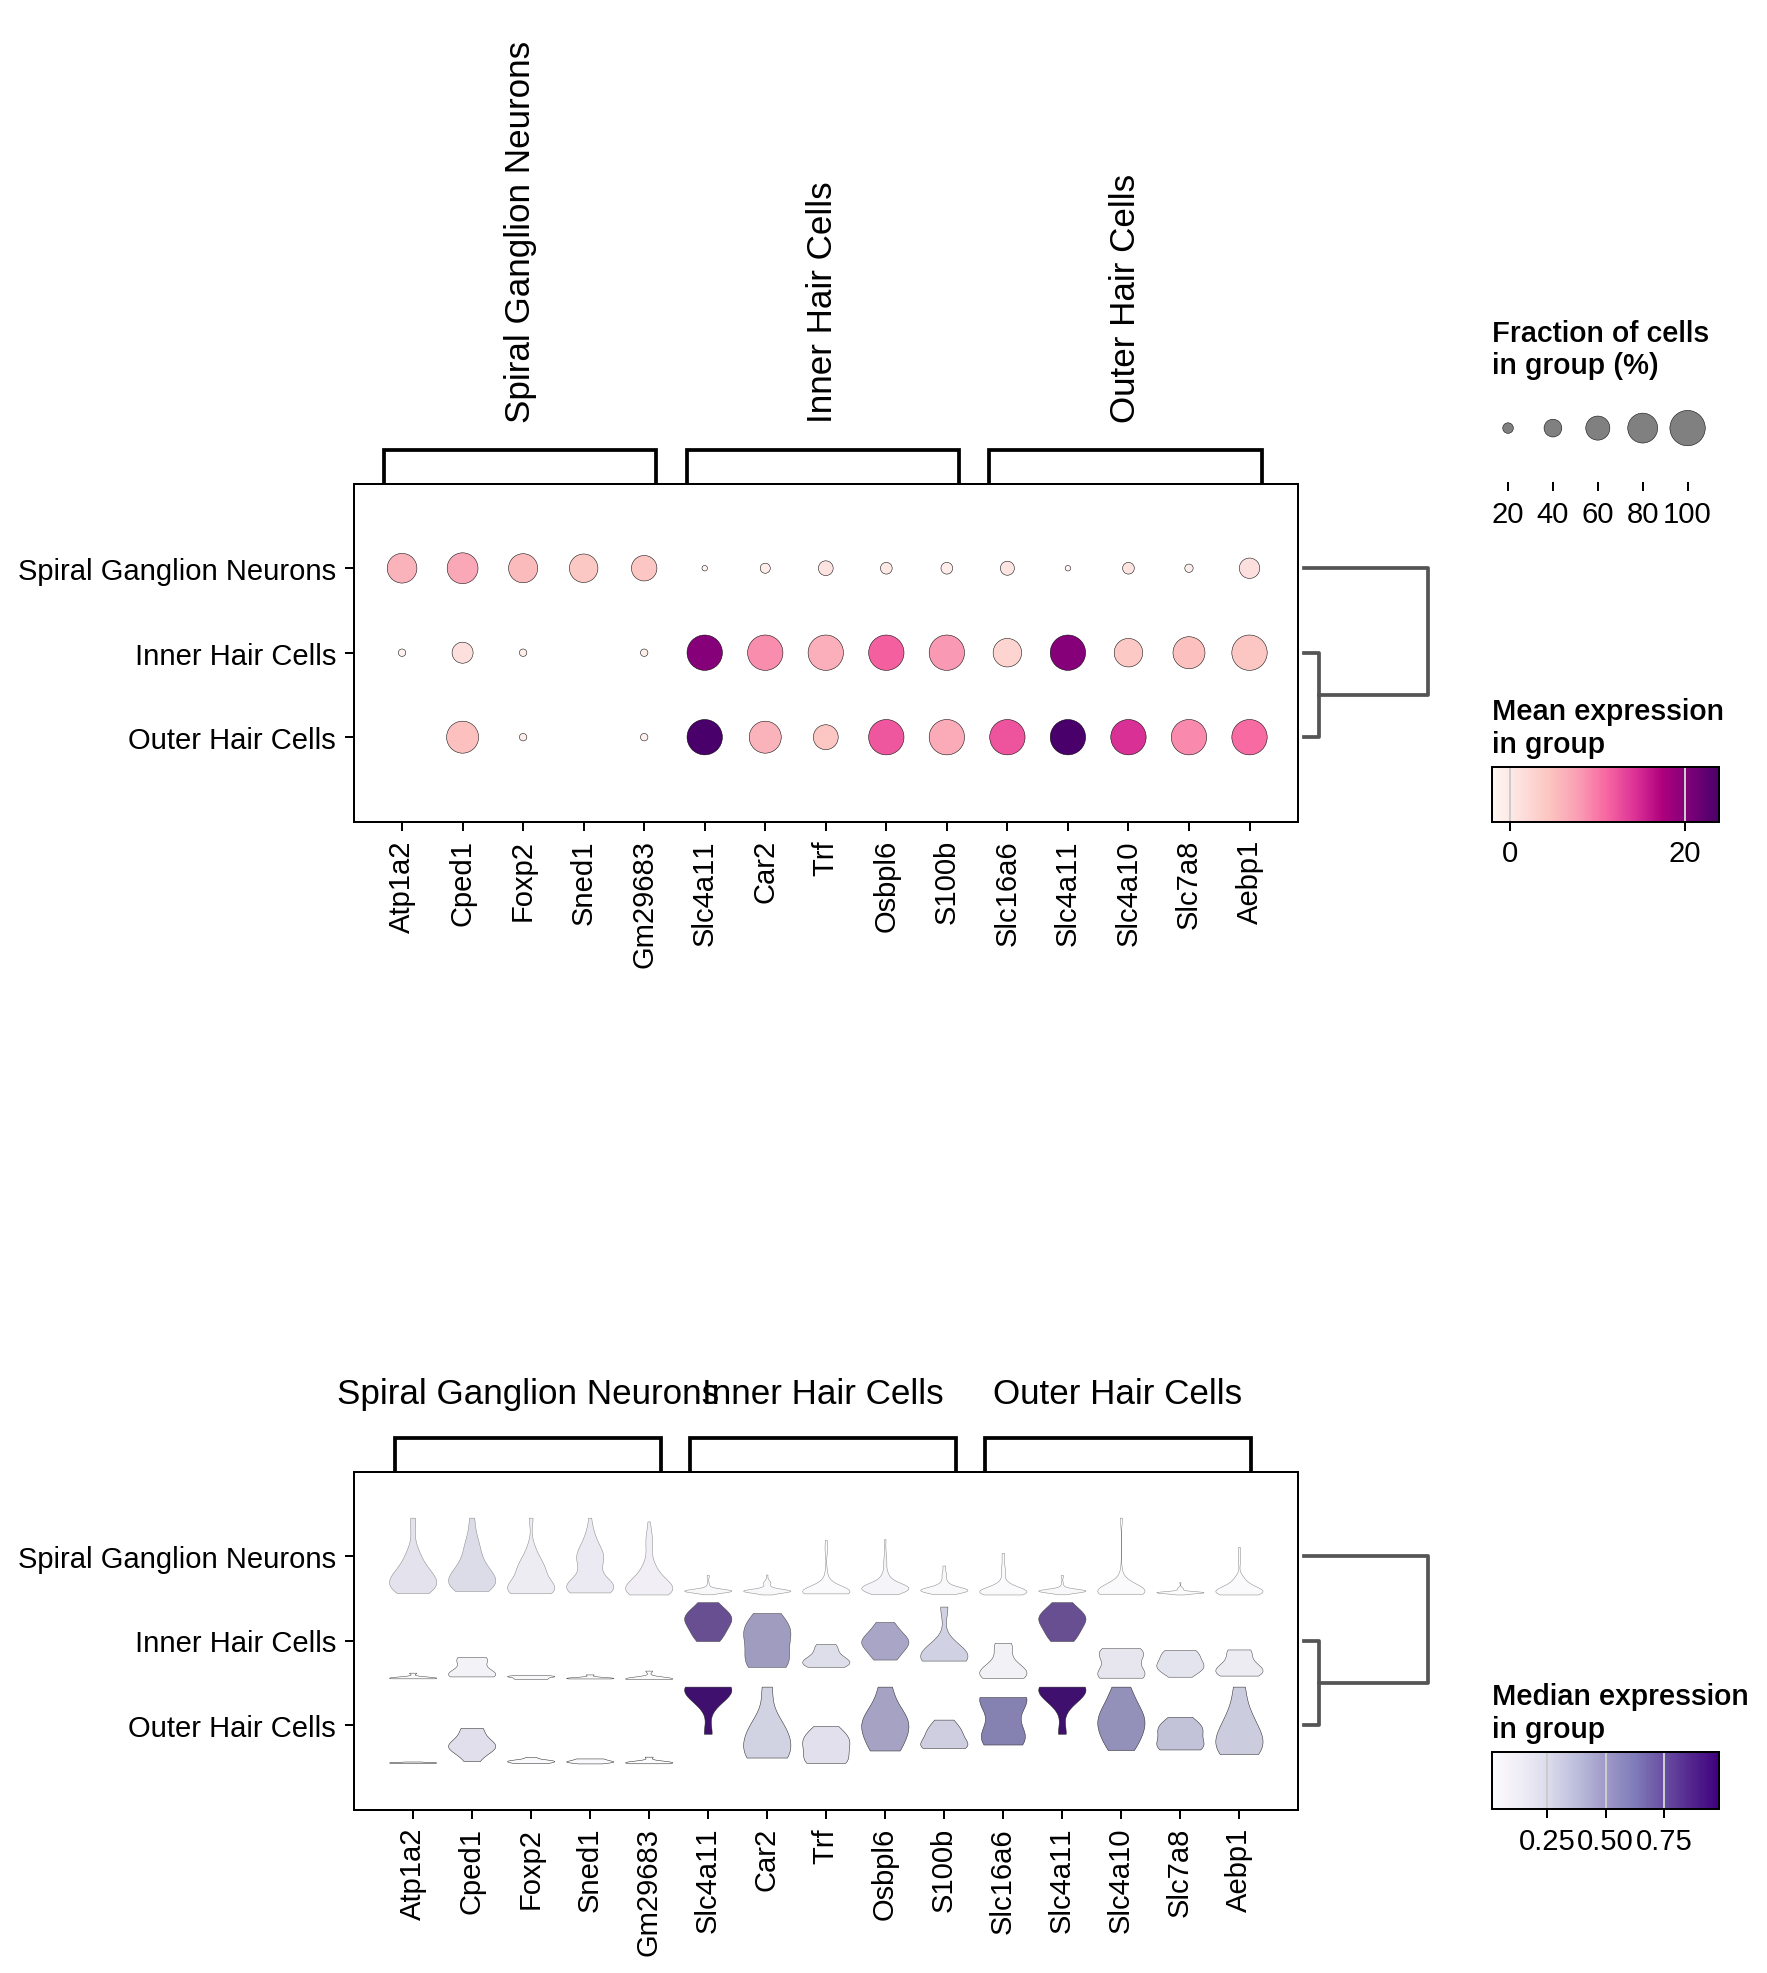

In [20]:
sc.tl.rank_genes_groups(adata,
                        groupby= "manual_celltypes",
                        method= "wilcoxon")

rc_context(rc= {"axes.facecolor": (1.0, 1.0, 1.0, 0.0)})
fig, axs = plt.subplots(2,1, figsize= (fig_width*3, fig_width*3.4), layout= "tight")

sc.pl.rank_genes_groups_dotplot(adata,
                                n_genes= 5,
                                ax= axs[0],
                                show= False,
                                cmap= "RdPu")

sc.pl.rank_genes_groups_stacked_violin(adata,
                                n_genes= 5,
                                ax= axs[1],
                                show= False,
                                standard_scale = "var",
                                var_group_rotation= 0,
                                cmap= "Purples")

fig.savefig(figures_folder + r"\RankedGeneGroups_TestPlates")
plt.show()

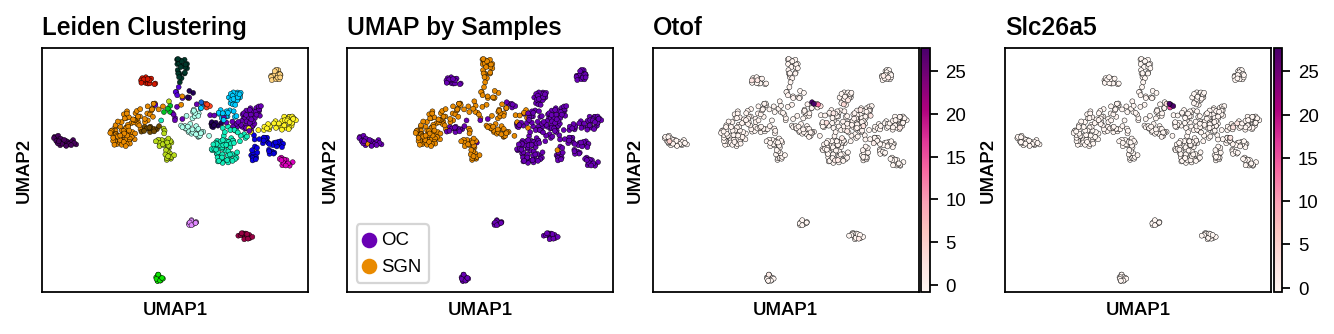

In [103]:
# Plotting some marker genes just for exploration
fig, ax = plt.subplots(1,4, figsize= (fig_width*2.5, fig_width*0.6), layout= "compressed")

dot_size= 20
sc.pl.umap(adata, color= ["Otof"],
           palette= my_cmap.colors,
           size= dot_size,
           edgecolor= "black",
           linewidth= 0.2,
           ax= ax[2],
           show= False)

sc.pl.umap(adata, color= ["Slc26a5"],
           palette= my_cmap.colors,
           size= dot_size,
           edgecolor= "black",
           linewidth= 0.2,
           ax= ax[3],
           show= False)

sc.pl.umap(adata, color= ["sample"],
           palette= my_cmap.colors,
           size= dot_size,
           edgecolor= "black",
           linewidth= 0.2,
           legend_loc= "lower left",
           ax= ax[1],
           title= "UMAP by Samples",
           show= False)

sc.pl.umap(adata, color= [f"leiden_{len(need_subclustering)}"],
           palette= my_cmap.colors,
           size= dot_size,
           edgecolor= "black",
           linewidth= 0.2,
           legend_loc= None,
           ax= ax[0],
           title= "Leiden Clustering",
           show= False)

fig.savefig(figures_folder + r"\Explorative_MarkerExpression_TestPlates.png")
plt.show()

c:\Users\jkorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_utils.py:481: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


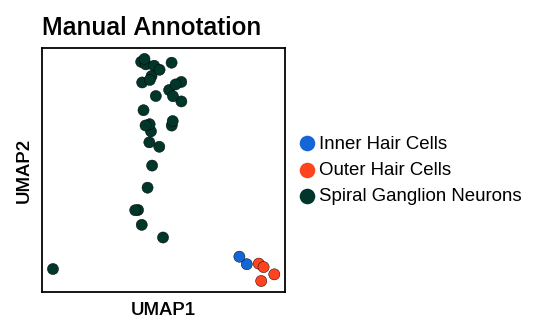

In [106]:
# Plotting some marker genes just for exploration
fig, ax = plt.subplots(1,1, figsize= (fig_width*1, fig_width*0.6), layout= "compressed")

dot_size= 100

sc.pl.umap(adata[adata.obs["manual_celltypes"].notna()],
           color= [f"manual_celltypes"],
           palette= [*my_cmap.colors[5:7].__reversed__(),
                     my_cmap.colors[19]],
           size= dot_size,
           edgecolor= "black",
           linewidth= 0.2,
           ax= ax,
           title= "Manual Annotation",
           show= False)

fig.savefig(figures_folder + r"\Explorative_MarkerExpression_zoom_TestPlates.png")
plt.show()